In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols

import acquire
import prepare
import model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# acquire.pull_csv_file()
df = acquire.read_telco_data()
df.shape

(7043, 24)

In [6]:
df = prepare.prep_data(df)
df.head(1)

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,tenure_years,is_churn
0,1,2,1,0003-MKNFE,0,0,0,0,9,1,...,1,0,59.9,542.4,0,Month-to-month,Mailed check,DSL,0,0


In [8]:
train, validate, test = prepare.split_data(df)

In [9]:
train.is_churn.mean()

0.2672189349112426

0.42625053441641725


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


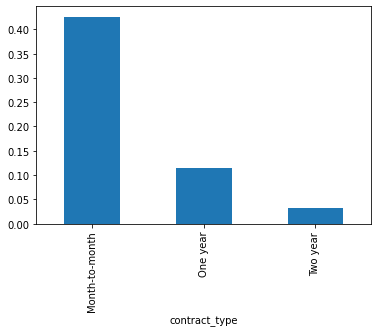

In [37]:
print(train.groupby('contract_type').is_churn.mean())
train.groupby('contract_type').is_churn.mean().plot('bar')

In [47]:
train.groupby('contract_type').monthly_charges.median()

contract_type
Month-to-month    72.90
One year          67.15
Two year          64.50
Name: monthly_charges, dtype: float64

In [46]:
delta_churn = train.groupby('contract_type').is_churn.mean()[0] - train.groupby('contract_type').is_churn.mean()[1]
percent_monthly = train[train.contract_type == 'Month-to-month'].is_churn.count()/ train.is_churn.count()
tenure_contract = train.groupby('contract_type').tenure.mean()[1] - train.groupby('contract_type').tenure.mean()[0] 
delta_churn, no_monthly, tenure_contract

(0.31157163533384846, 0.5536094674556213, 24.21184708041937)

In [49]:
tenure_contract*delta_churn*

7.543724789299328

In [11]:
train.is_churn.mean()

0.2672189349112426

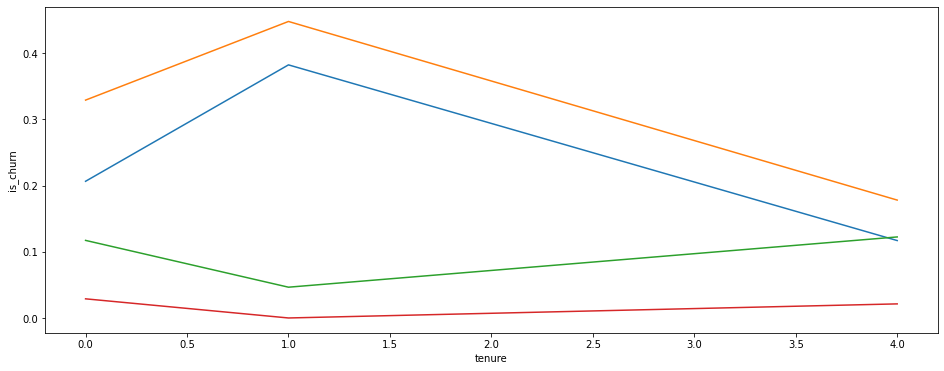

In [12]:
x = train.tenure // 6
y = train.groupby(train.tenure // 6).is_churn.mean()
y1 = train[train.contract_type == 'Month-to-month'].groupby(train.tenure // 6).is_churn.mean()
y2 = train[train.contract_type == 'One year'].groupby(train.tenure // 6).is_churn.mean()
y3 = train[train.contract_type == 'Two year'].groupby(train.tenure // 6).is_churn.mean()

plt.figure(figsize=(16,6))
plt.legend
sns.lineplot(x, y, data=train, ci=None)
sns.lineplot(x, y1, data=train, ci=None)
sns.lineplot(x, y2, data=train, ci=None)
sns.lineplot(x, y3, data=train, ci=None)

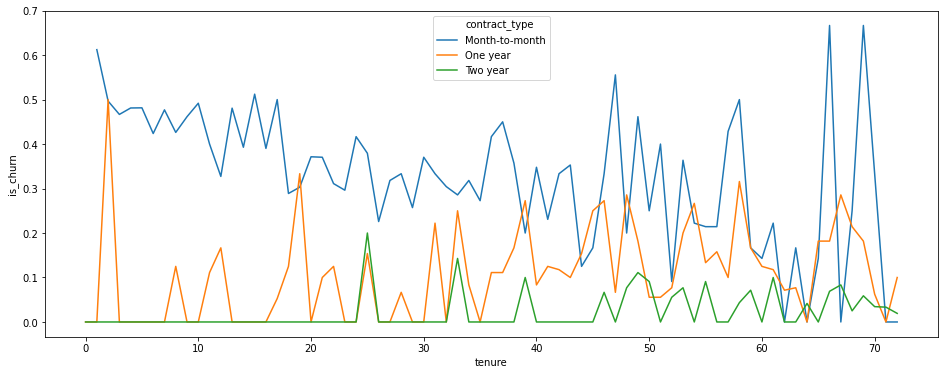

In [13]:
plt.figure(figsize=(16,6))
sns.lineplot('tenure', 'is_churn', hue='contract_type', data=train, ci=None)

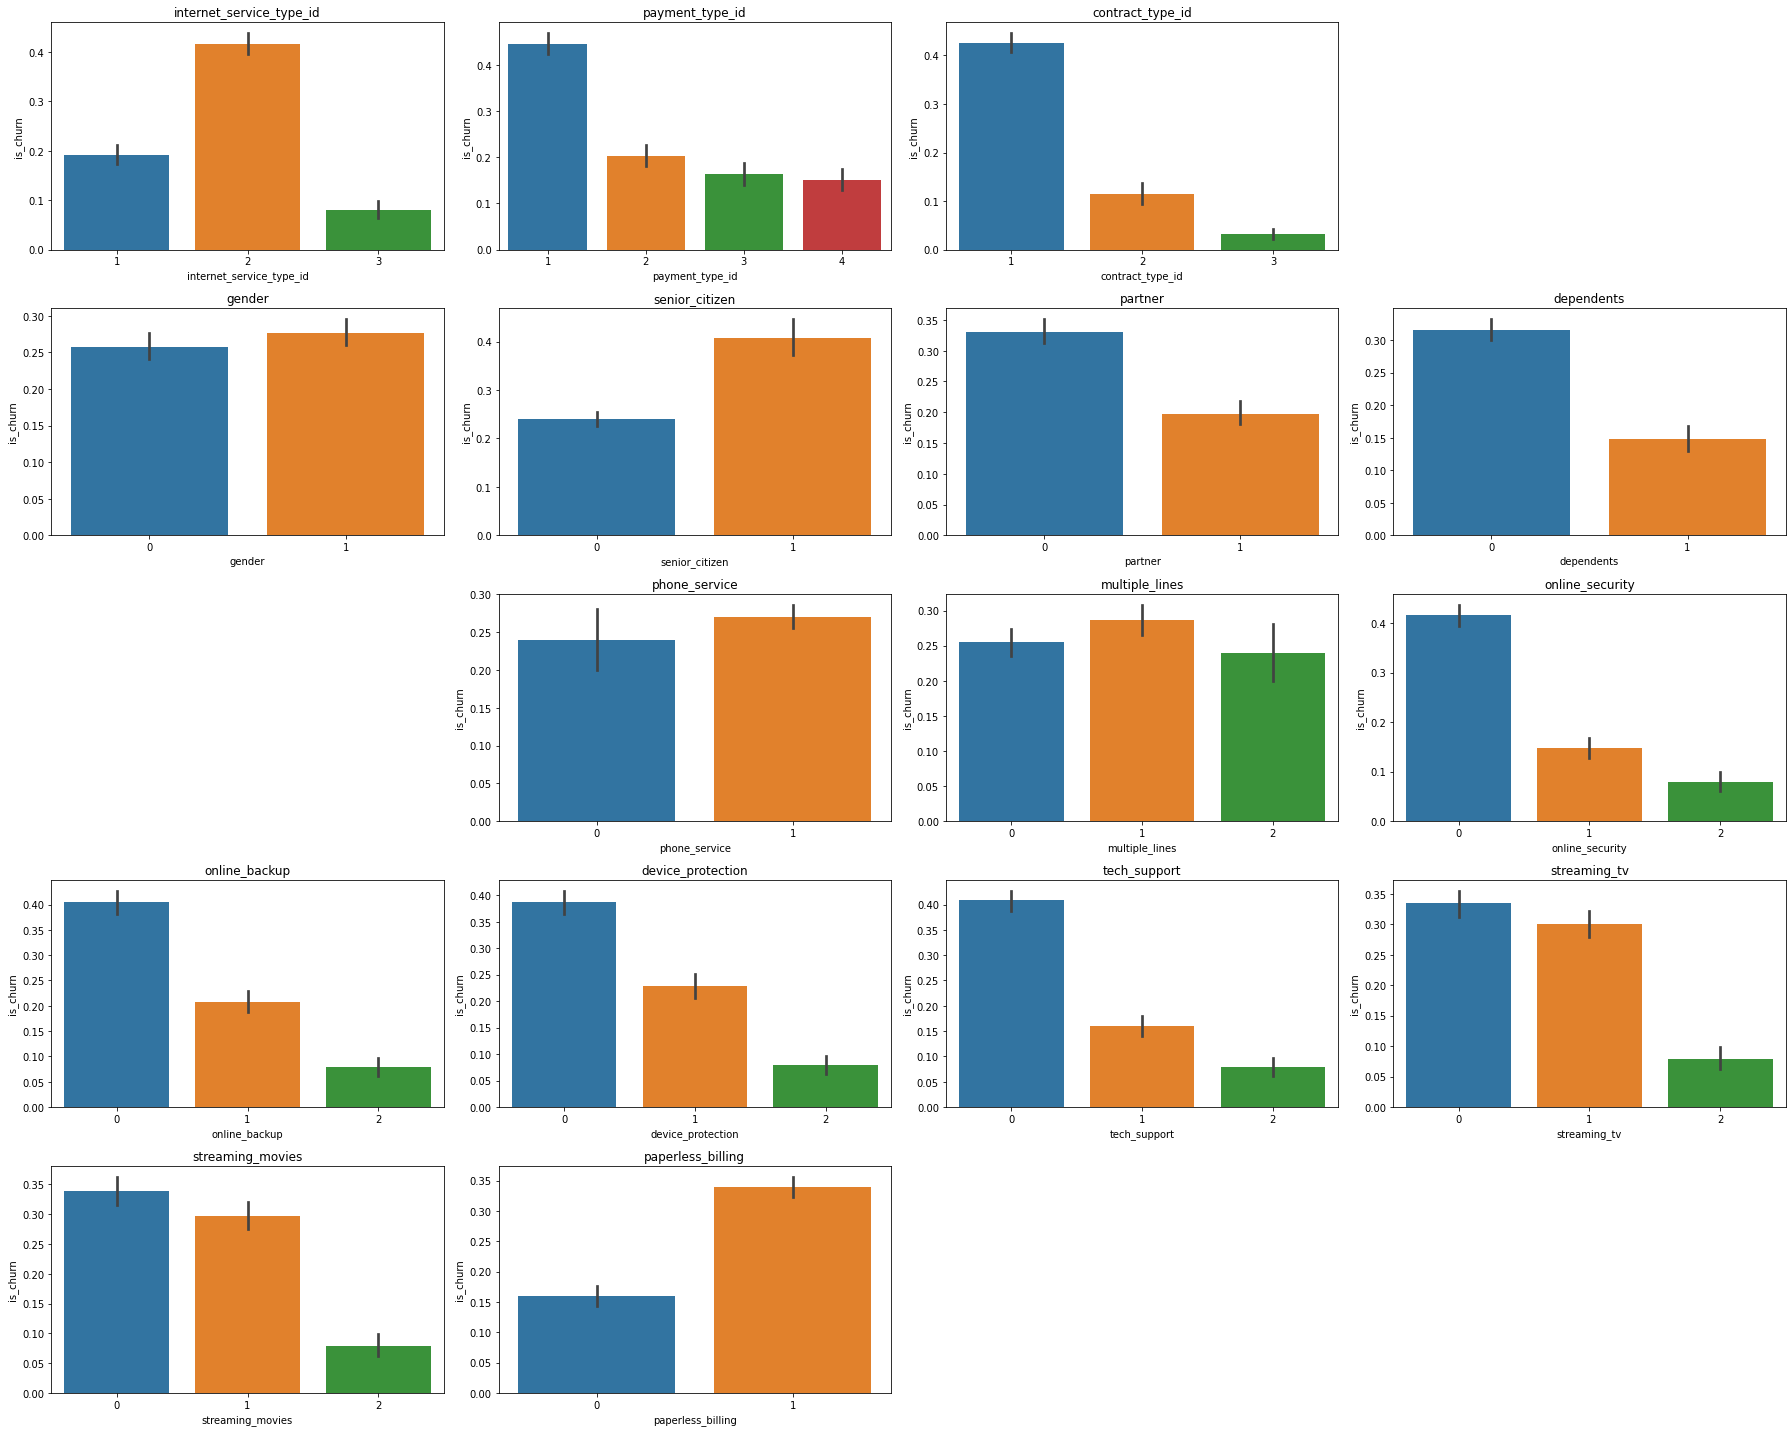

In [14]:
f = plt.figure(figsize=(25,20))
for i in range(0,20):
    if len(train.groupby(train.iloc[:,i])) < 5:
        f.add_subplot(5,4, i+1)
        sns.barplot(data=train, y="is_churn", x=train.iloc[:,i])
        plt.title(train.columns[i])
plt.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x121b8fc50> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


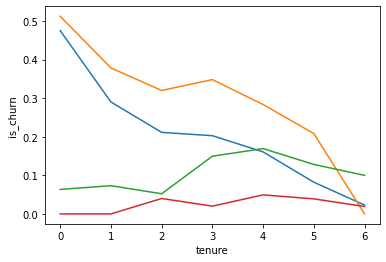

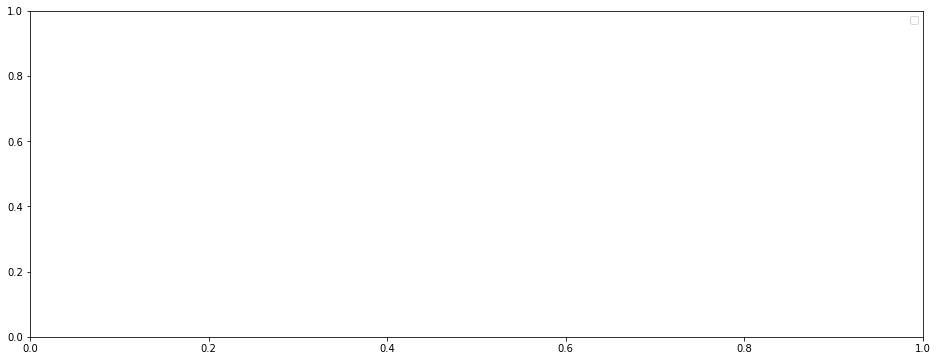

In [15]:
x = train.groupby(train.tenure // 12).tenure.sum().index
y = train.groupby(train.tenure // 12).is_churn.mean()
y1 = train[train.contract_type == 'Month-to-month'].groupby(train.tenure // 12).is_churn.mean()
y2 = train[train.contract_type == 'One year'].groupby(train.tenure // 12).is_churn.mean()
y3 = train[train.contract_type == 'Two year'].groupby(train.tenure // 12).is_churn.mean()

line1 = sns.lineplot(x, y, data=train, ci=None, legend='full')
line2 = sns.lineplot(x, y1, data=train, ci=None)
line3 = sns.lineplot(x, y2, data=train, ci=None)
line4 = sns.lineplot(x, y3, data=train, ci=None)


plt.figure(figsize=(16,6))
plt.legend((line1, line2, line3, line4), ('Overall', 'Month-to-month', 'One year', 'Two years'))

line1
line2
line3
line4

In [16]:
train.groupby('contract_type').is_churn.mean()

contract_type
Month-to-month    0.426251
One year          0.114679
Two year          0.031558
Name: is_churn, dtype: float64

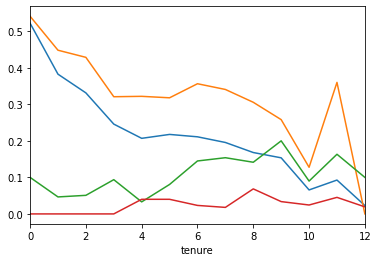

In [17]:
train.groupby(train.tenure // 6).is_churn.mean().plot()
train[train.contract_type == 'Month-to-month'].groupby(train.tenure // 6).is_churn.mean().plot()
train[train.contract_type == 'One year'].groupby(train.tenure // 6).is_churn.mean().plot()
train[train.contract_type == 'Two year'].groupby(train.tenure // 6).is_churn.mean().plot()



In [18]:
train.groupby(train.tenure // 6).tenure.sum().index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='tenure')

In [19]:
train['tenure_grouped'] = train.tenure // 6

In [20]:
train.groupby('tenure_grouped').tenure.sum().index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='tenure_grouped')

In [21]:
train.tenure_grouped

440      1
67       0
600      0
4883    11
1258    10
        ..
1794     9
817      0
901      0
1987     9
6958     2
Name: tenure_grouped, Length: 4225, dtype: int64

## Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [22]:
train.is_churn.value_counts()

0    3096
1    1129
Name: is_churn, dtype: int64

In [23]:
# x = train.groupby((train.monthly_charges // 10)*10).is_churn.mean().index
# y = train.groupby((train.monthly_charges//10)*10).is_churn.mean().plot()

# sns.lineplot(x, y)
train.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,tenure_years,is_churn,tenure_grouped
440,1,4,1,3701-SFMUH,0,0,1,1,7,1,...,0,69.70,516.15,0,Month-to-month,Credit card (automatic),DSL,0,0,1
67,1,1,1,0674-EYYZV,1,0,0,0,1,1,...,1,54.65,54.65,0,Month-to-month,Electronic check,DSL,0,0,0
600,1,4,1,4918-QLLIW,0,0,0,0,3,1,...,0,53.40,188.70,1,Month-to-month,Credit card (automatic),DSL,0,1,0
4883,2,4,2,6097-EQISJ,1,0,1,1,66,1,...,1,102.45,6615.15,1,One year,Credit card (automatic),Fiber optic,5,1,11
1258,1,3,2,0654-PQKDW,1,0,1,1,62,1,...,1,70.75,4263.45,0,One year,Bank transfer (automatic),DSL,5,0,10


In [24]:
train.internet_service_type.value_counts(), train.internet_service_type_id.value_counts()

(Fiber optic    1866
 DSL            1454
 None            905
 Name: internet_service_type, dtype: int64, 2    1866
 1    1454
 3     905
 Name: internet_service_type_id, dtype: int64)

In [25]:
# # male_mask = train.gender == 0
# # female_mask = train.gender == 1
churn = pd.DataFrame(train.groupby((train.monthly_charges // 5)*5).is_churn.mean())
# # churn_output['is_male'] = train[male_mask].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# # churn_output["is_female"] = train[female_mask].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["paperless"] = train[train.paperless_billing == 1].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["mailed_bill"] = train[train.paperless_billing == 0].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["fiber_optic"] = train[train.internet_service_type_id == 2].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["dsl"] = train[train.internet_service_type_id == 1].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["no_internet"] = train[train.internet_service_type_id == 3].groupby((train.monthly_charges // 5)*5).is_churn.mean()

churn.head()

,is_churn
monthly_charges,
15.0,0.095890
20.0,0.101099
25.0,0.121212
30.0,0.339623
35.0,0.237288


In [26]:
churn = pd.DataFrame(train.groupby((train.monthly_charges // 5)*5).is_churn.mean())
def subset_churn_data(column_list):
    df = pd.DataFrame(train.groupby((train.monthly_charges // 5)*5).is_churn.mean())
    for c in column_list:
        subset_list = train[c].value_counts().index
        for i in subset_list:
            df[i] = train[train[c] == i].groupby((train.monthly_charges // 5)*5).is_churn.mean()
    return df
    

In [27]:
column_list = ['internet_service_type', 'payment_type', 'contract_type', 'dependents']
churn = subset_churn_data(column_list)
churn.head(1)

,is_churn,Fiber optic,DSL,None,Electronic check,Mailed check,Credit card (automatic),Bank transfer (automatic),Month-to-month,Two year,One year,0,1
monthly_charges,,,,,,,,,,,,,
15.0,0.09589,NaN,NaN,0.09589,0.228571,0.107143,0.026316,0.068966,0.195946,0.01626,0.042553,0.102222,0.085714


In [28]:
def make_churn_bar_plots(df):
    f = plt.figure(figsize=(16,100))
    x = churn.shape[1]
    for i in range(0, x):
        f.add_subplot(20, 1, i+1)
        sns.barplot(data=churn, y=churn.iloc[:,i], x=churn.index)
        plt.title(churn.columns[i])
    plt.tight_layout()
    plt.show() 


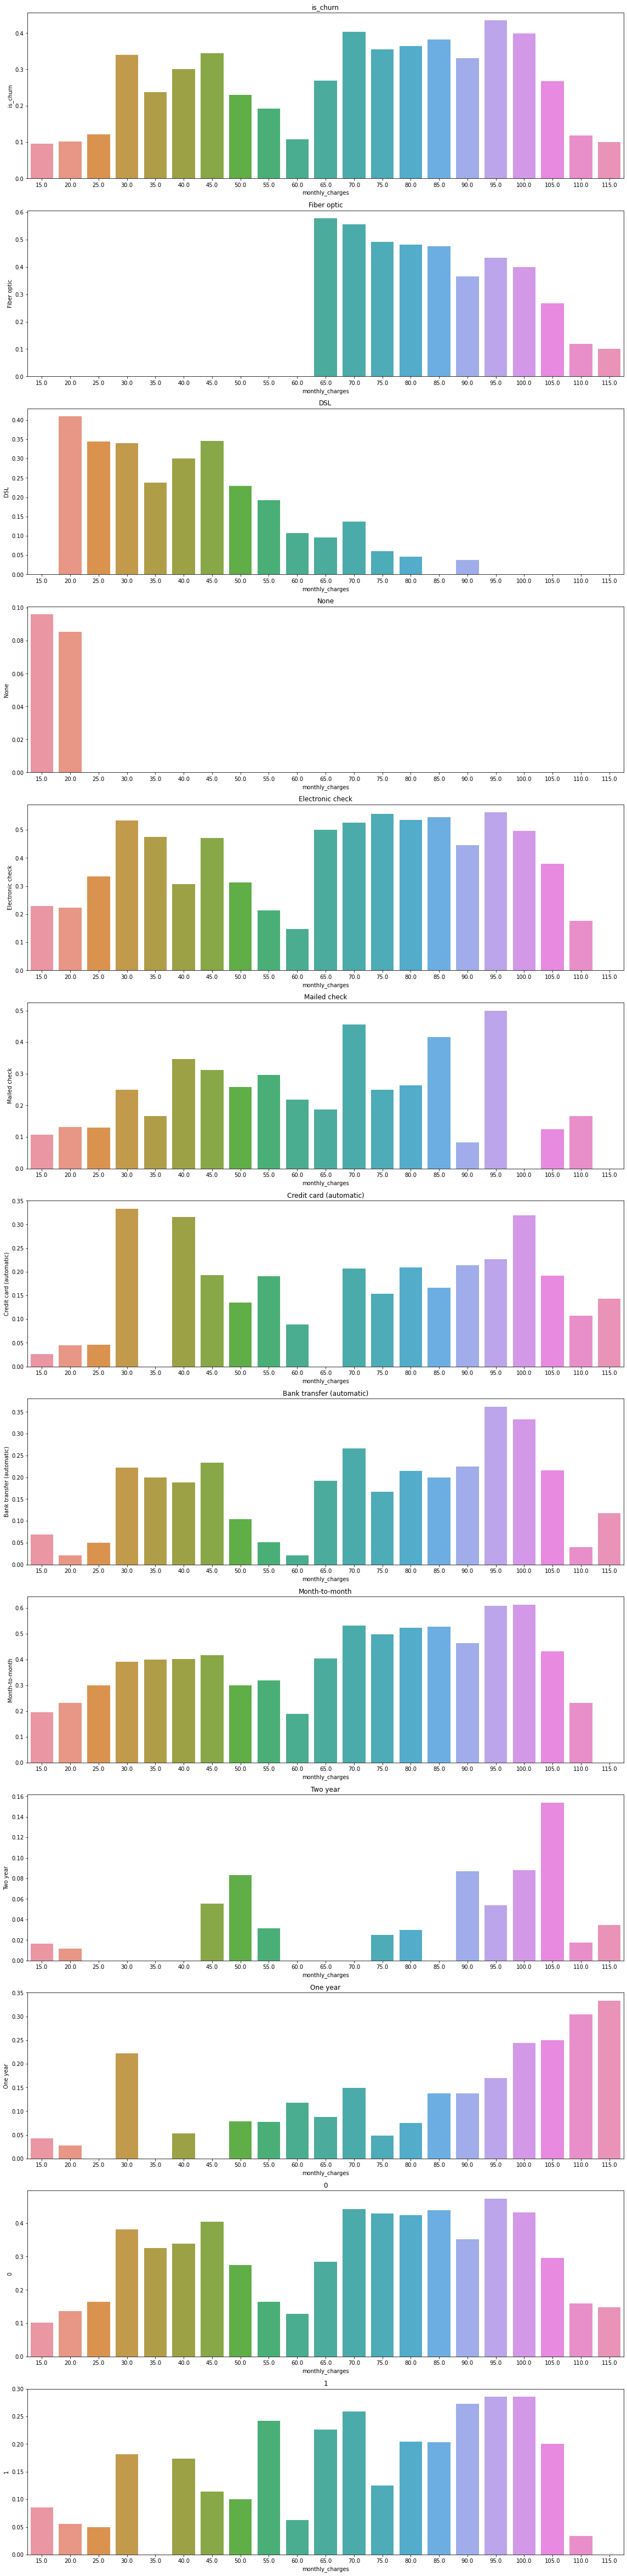

In [29]:
make_churn_bar_plots(churn)

In [30]:
# subset_churn_data('internet_service_type').index[0]

AttributeError: 'DataFrame' object has no attribute 'fiber_optic'

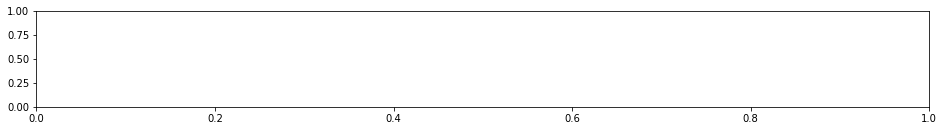

In [31]:
plt.figure(figsize=(16,6))

plt.subplot(3,1,1)
sns.barplot(x, churn.fiber_optic)
plt.subplot(3,1,2)
sns.barplot(x, churn.dsl)
plt.subplot(3,1,3)
sns.barplot(x, churn.no_internet)

In [ ]:
# f = plt.figure(figsize=(25,20))

# for i in range(0,21):
#     if len(train.groupby(train.iloc[:,i+3])) < 5:
#         f.add_subplot(5,5, i+1)
#         sns.lineplot(data=train, y="is_churn", x=train.iloc[:,i+3])
#         plt.title(train.columns[i+3])
# plt.tight_layout()
# plt.show()

In [ ]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="mean").reset_index()

In [ ]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="count").reset_index()

In [ ]:
train.head()

In [ ]:
pd.crosstab(columns=train.is_churn, index=([train.contract_type, train.internet_service_type]), values=train.is_churn, aggfunc='mean')

In [ ]:
true_mask = train.is_churn == True
false_mask = train.is_churn == False

true_mask

In [ ]:
X = train[['tenure']]
y = train[['monthly_charges']]

lm_churn = LinearRegression().fit(X=X, y=y)
lm_no_churn =

In [ ]:
train.churn = train.churn.replace({1:"yes", 0: "no"})

In [ ]:
train['combine_churn_contract_type'] = train.churn + " " + train.contract_type

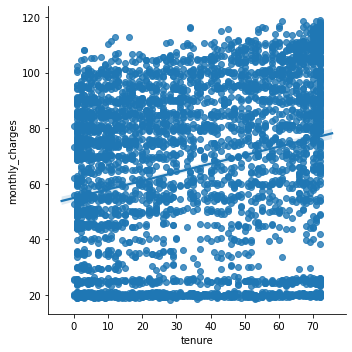

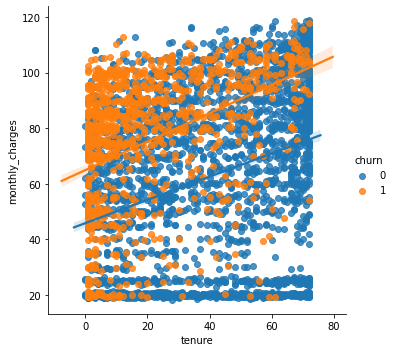

In [50]:
sns.lmplot(data=train, x='tenure', y='monthly_charges')
sns.lmplot(data=train, x='tenure', y='monthly_charges', hue = 'churn')

In [ ]:
sns.lmplot(data=train, x='tenure', y='monthly_charges', hue = 'contract_type')
plt.figure(figsize=(16,16))

In [ ]:
internet_churn = train[train.internet_service_type != "None"].is_churn.mean()
phone_churn = train[train.internet_service_type == "None"].is_churn.mean()
internet_count = train[train.internet_service_type != "None"].is_churn.count()
phone_count = train[train.internet_service_type == "None"].is_churn.count()
internet_m_value = train[train.internet_service_type != "None"].monthly_charges.mean()
phone_m_value = train[train.internet_service_type == "None"].monthly_charges.mean()
internet_tenure = train[train.internet_service_type != "None"].tenure.mean()

print(internet_churn, phone_churn)
print(internet_count, phone_count)
print(internet_m_value, phone_m_value)


In [ ]:
telco = acquire.read_telco_data()
telco.shape

In [ ]:
telco = telco[telco.internet_service_type != "None"]
telco.shape

In [ ]:
train, validate, test = prepare.split_data(telco)

In [ ]:
train, validate, test = prepare.split_data(telco)
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn
train.shape

In [ ]:
evaluation = pd.DataFrame({"actual": y_train})
evaluation["baseline"] = 0

In [ ]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.baseline), index = labels, columns = labels)
matrix

In [ ]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [ ]:
X_train.shape

In [ ]:
logict, y_pred = model.run_lg(X_train, y_train)
evaluation["logistic_regression_1"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(logict, y_pred, y_train)

In [ ]:
print(accuracy_score)
print(matrix)
report

In [ ]:
coef = logict.coef_[0]
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = logict.coef_[0]
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

In [ ]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

In [ ]:
telco = acquire.read_telco_data()

In [ ]:
telco = telco[telco.internet_service_type != "None"]
telco.shape

In [ ]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [ ]:
for i in range(1,26):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

In [ ]:
clf, y_pred = model.run_clf(X_train, y_train, 6)
evaluation["decision_tree_model"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)

In [ ]:
print(accuracy_score)
print(matrix)
report

In [ ]:
telco = acquire.read_telco_data()
telco = telco[telco.internet_service_type != "None"]
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [ ]:
# We want to find what hyperameter will gives us the best result, so we look at the scores for different parameters. 
for i in range(1,20):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

In [ ]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 6)
evaluation["rf_2"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)
report

In [ ]:
y_pred = rf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)

print(accuracy_score)
print(matrix)
report

In [ ]:
telco = acquire.read_telco_data()
telco = telco.drop(columns=('monthly_charges'))
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [ ]:
X_train = X_train.drop(columns=('monthly_charges))

In [ ]:
train, validate, test = prepare.split_data(telco)
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn
train.shape

In [ ]:
X_train.head()

In [ ]:
# We want to find what hyperameter will gives us the best result, so we look at the scores for different parameters. 
for i in range(1,20):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

In [ ]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 6)
# evaluation["rf_2"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)
report

In [ ]:
y_pred = rf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)

print(accuracy_score)
print(matrix)
report

In [ ]:
marketing_expense = [765, 760, 761, 750, 751, 769, 790, 732, 735, 768, 793, 748]
customers = [26524, 26737, 26952, 27161, 27425, 27621, 27855, 28103, 28454, 28657, 28967, 29235] 
charthouse = pd.DataFrame(np.array([marketing_expense, customers]).transpose(), columns = ['mark', 'cust'])


In [ ]:
charthouse

In [ ]:
X = charthouse[['mark']]
y = charthouse[['cust']]
sns.lmplot(data=charthouse, x='mark', y='cust')